## Load Data and Libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)

# Load dataset
df = pd.read_csv("EM.csv")  # Adjust the path if needed


## EDA: Analyze Two Features

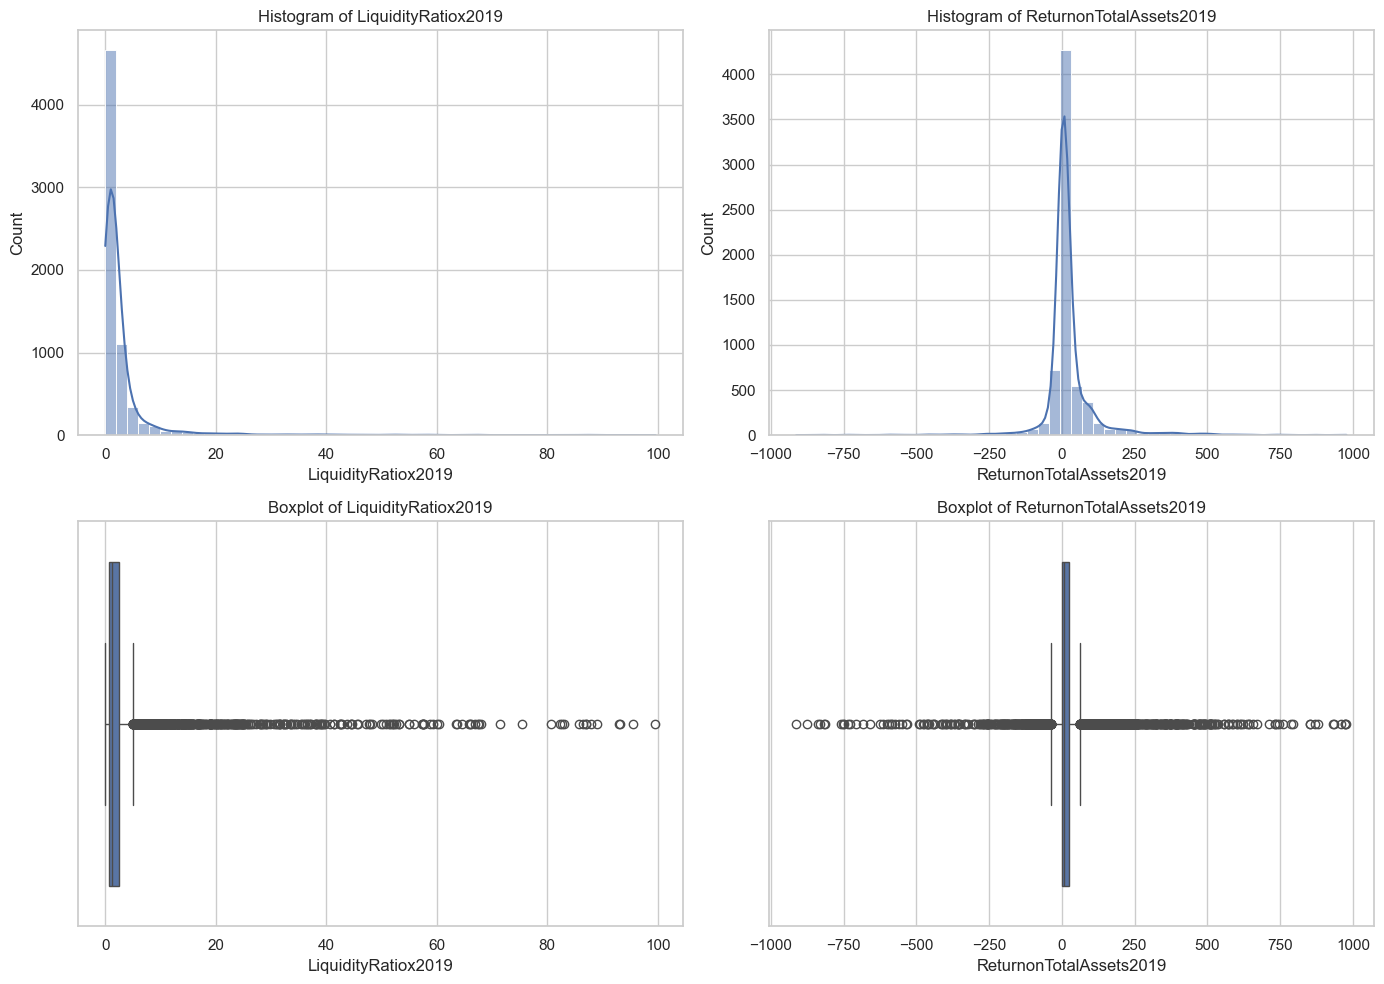

In [7]:
# Choose two meaningful features
eda_features = ['LiquidityRatiox2019', 'ReturnonTotalAssets2019']
sns.set(style="whitegrid")
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Histograms
sns.histplot(df[eda_features[0]].dropna(), bins=50, kde=True, ax=axs[0, 0])
axs[0, 0].set_title(f'Histogram of {eda_features[0]}')
sns.histplot(df[eda_features[1]].dropna(), bins=50, kde=True, ax=axs[0, 1])
axs[0, 1].set_title(f'Histogram of {eda_features[1]}')

# Boxplots
sns.boxplot(x=df[eda_features[0]], ax=axs[1, 0])
axs[1, 0].set_title(f'Boxplot of {eda_features[0]}')
sns.boxplot(x=df[eda_features[1]], ax=axs[1, 1])
axs[1, 1].set_title(f'Boxplot of {eda_features[1]}')

plt.tight_layout()
plt.show()


## Preprocessing and Feature Engineering

In [11]:
# Create target variable
mean_score = df['Creditscore'].mean()
df['CreditLevel'] = (df['Creditscore'] > mean_score).astype(int)

# Use only numerical features (excluding target and score)
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
for col in ['Creditscore', 'CreditLevel']:
    if col in numerical_cols:
        numerical_cols.remove(col)

X = df[numerical_cols].fillna(df[numerical_cols].mean())
y = df['CreditLevel']

# Train-test split and scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Cross-Validation for Both Models

In [15]:
# Define models
rf_model = RandomForestClassifier(random_state=123)
lr_model = LogisticRegression(max_iter=1000, random_state=123)

# 5-fold CV
rf_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
lr_scores = cross_val_score(lr_model, X_train_scaled, y_train, cv=5, scoring='accuracy')

# Print results
print(" Cross-Validation Accuracy (5-Fold):")
print(f"Random Forest       -> Mean: {rf_scores.mean():.4f}, Std Dev: ±{rf_scores.std():.4f}")
print(f"Logistic Regression -> Mean: {lr_scores.mean():.4f}, Std Dev: ±{lr_scores.std():.4f}")


 Cross-Validation Accuracy (5-Fold):
Random Forest       -> Mean: 0.9928, Std Dev: ±0.0017
Logistic Regression -> Mean: 0.9916, Std Dev: ±0.0012


## Evaluation on Test Set (Random Forest)


 Classification Report (Random Forest on Test Set):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1359
           1       0.99      0.99      0.99      1094

    accuracy                           0.99      2453
   macro avg       0.99      0.99      0.99      2453
weighted avg       0.99      0.99      0.99      2453



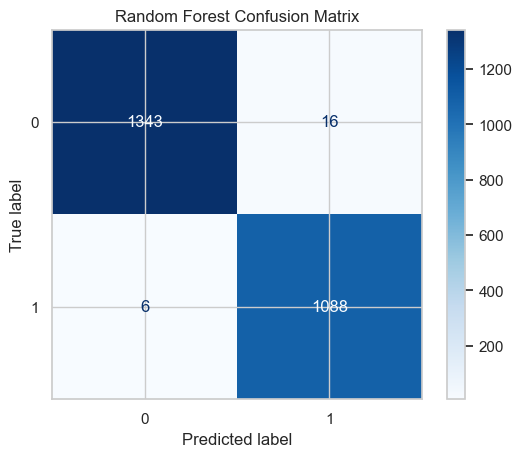

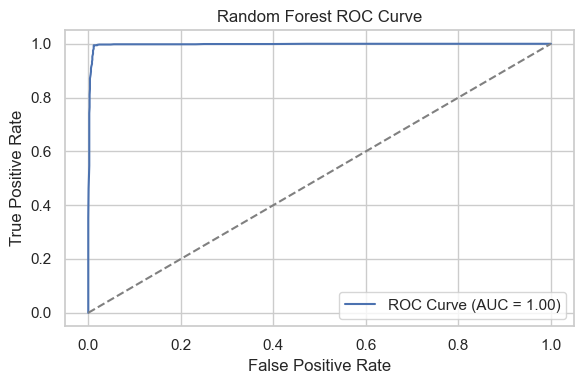

In [23]:
# Fit Random Forest and predict
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
y_prob_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

# Classification report
print("\n Classification Report (Random Forest on Test Set):")
print(classification_report(y_test, y_pred_rf))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=rf_model.classes_)
disp.plot(cmap="Blues")
plt.title("Random Forest Confusion Matrix")
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob_rf)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()


## Feature Importance from Random Forest

In [25]:
# Get feature importance
importances = rf_model.feature_importances_
feature_names = X.columns

feat_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display top 10
print("\n Top 10 Most Important Features for Predicting CreditLevel:")
print(feat_importance_df.head(10).to_string(index=False))



 Top 10 Most Important Features for Predicting CreditLevel:
                   Feature  Importance
       Likelihoodoffailure    0.401748
       Previouscreditscore    0.129450
      TotalAssetsthGBP2019    0.053423
   TradeCreditorsthGBP2019    0.040598
    CurrentAssetsthGBP2019    0.036595
ShareholdersFundsthGBP2019    0.036169
         CreditlimitGBPGBP    0.034187
      TotalAssetsthGBP2020    0.025793
      NetCurrentAssets2019    0.021400
         TurnoverthGBP2019    0.015576


## Compare Random Forest vs Logistic Regression on Test Set


 Classification Report: Logistic Regression on Test Set
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1359
           1       0.98      0.99      0.99      1094

    accuracy                           0.99      2453
   macro avg       0.99      0.99      0.99      2453
weighted avg       0.99      0.99      0.99      2453



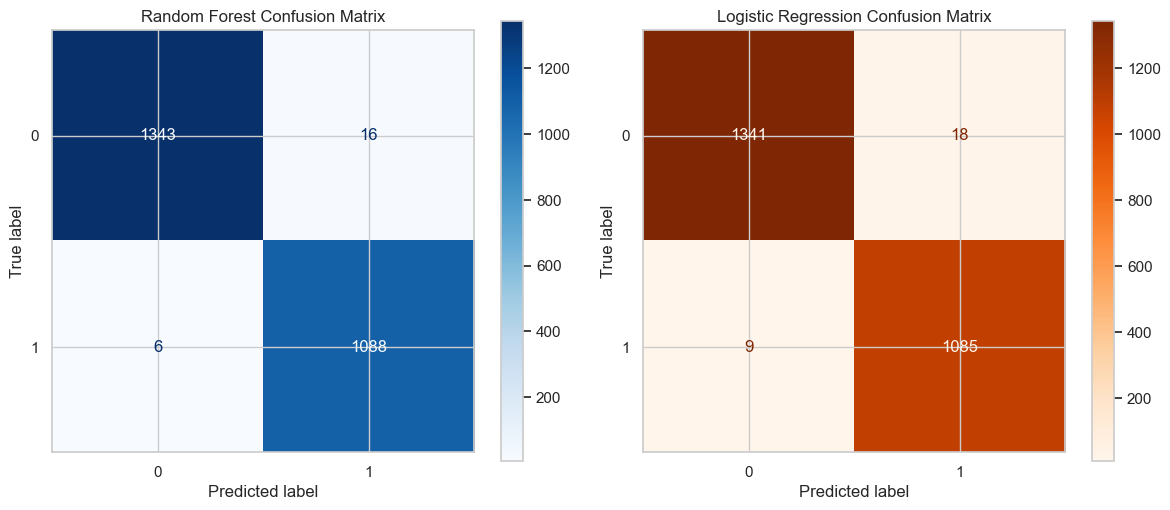

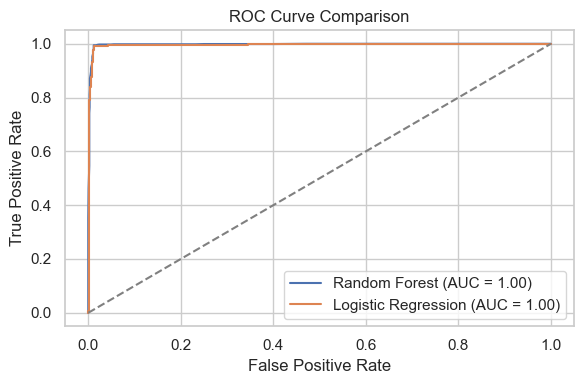

In [27]:
# 1. Fit Logistic Regression
lr_model.fit(X_train_scaled, y_train)

# 2. Predict on test set
y_pred_lr = lr_model.predict(X_test_scaled)
y_prob_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# 3. Classification Reports
print("\n Classification Report: Logistic Regression on Test Set")
print(classification_report(y_test, y_pred_lr))

# 4. Confusion Matrices
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# RF
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, ax=ax[0], cmap='Blues')
ax[0].set_title("Random Forest Confusion Matrix")

# LR
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr, ax=ax[1], cmap='Oranges')
ax[1].set_title("Logistic Regression Confusion Matrix")

plt.tight_layout()
plt.show()

# 5. ROC Curves
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
roc_auc_rf = auc(fpr_rf, tpr_rf)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(6, 4))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.2f})")
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {roc_auc_lr:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.tight_layout()
plt.show()


## Bar chart of Top 10 Feature Importances

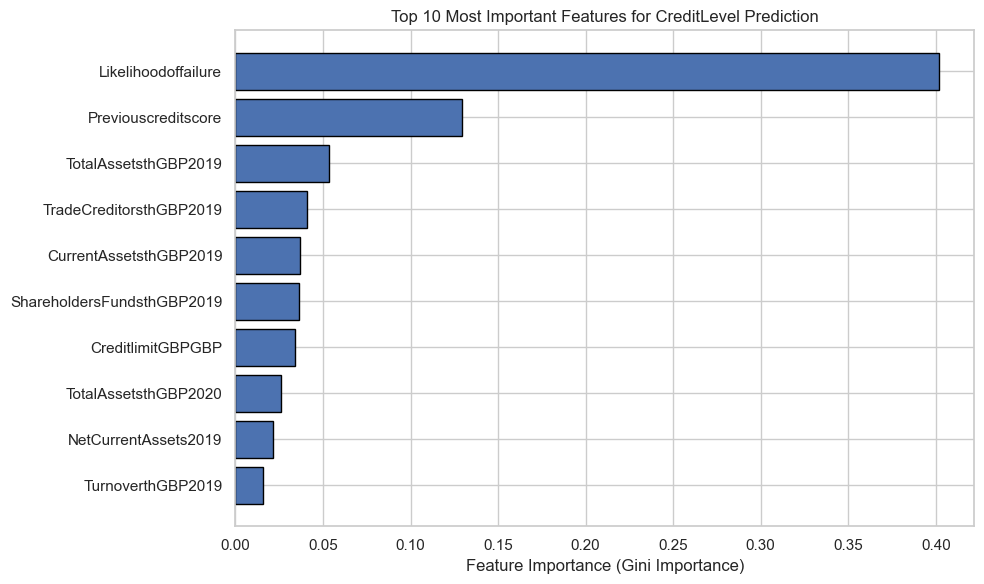

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importances from the fitted Random Forest model
importances = rf_model.feature_importances_
feature_names = X.columns

# Create DataFrame and sort
feat_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Select top 10 features
top10 = feat_importance_df.head(10)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top10['Feature'], top10['Importance'], edgecolor='black')
plt.gca().invert_yaxis()  # Highest at top
plt.title("Top 10 Most Important Features for CreditLevel Prediction")
plt.xlabel("Feature Importance (Gini Importance)")
plt.tight_layout()
plt.show()
